Run the following shell commands if you want to mount your Drive and change directory to Drive:

In [1]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
#change your directory to Drive
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


Run the following cell if you want to unzip the zips in Drive:

In [3]:
#unzipping the zip files and deleting the zip files
!unzip assets.zip && !unzip variables.zip && !unzip model_histories.zip && !unzip saved_files.zip && rm assets.zip && rm variables.zip && rm model_histories.zip && rm saved_files.zip

unzip:  cannot find or open assets.zip, assets.zip.zip or assets.zip.ZIP.


Run all imports and functions:

In [35]:
# Dependencies 
import numpy as np
import pandas as pd
import json
import pickle
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [5]:
# Helper to load preprocess data
def load_train_test_data(features_train, features_test, labels_train, labels_test, fashion_labels):
  ''' Loads samples and labels of training testing data
  Args:
  - features_train (string): path to training samples
  - features_test (string): path to testing samples
  - labels_train (string): path to training sample labels
  - labels_test (string): path to testing sample labels 
  - fashion_labels (string): path to class names 

  Returns:
  - features_train (array): array of training samples
  - features_test (array): array of testing samples
  - labels_train (array): array of training sample labels
  - labels_test (array): array of testing sample labels 
  - fashion_labels (array): array of class names in order of integer encoding
  '''
  paths = [val for key, val in locals().items()]
  vars = []
  #iterate through function parameters
  for file_path in paths:
    #opens file and parse to array
    with open(file_path, 'rb') as f:
      vars.append(np.load(f))
  
  return tuple(vars)

In [17]:
# Helper to run the model
def run_model(model, features_train, labels_train, epochs, batch_size, call_backs=None):
  ''' Runs the given model with given data
  Args:
  - model (Model): A Keras Model 
  - features_train (Array): array of training features
  - labels_train (Array): array of training labels 
  - epochs (int): epochs to run model for
  - batch_size (int): samples to be run every update
  - call_backs (array): array of Keras callbacks

  Returns:
  - model_hist (History): history of the model
  '''

  #train model
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
  model_hist = model.fit(features_train, labels_train, epochs=epochs, 
                          batch_size=batch_size, 
                          validation_split=0.1, callbacks=call_backs)
  
  return model_hist

In [28]:
# visualization and evaluation of model

def get_accuracy_loss(model_names, model_histories):
  ''' Get last accuracy/loss from model histories
  Args:
  - model_names (array): array of model names
  - model_histories (array): array of model history dicts

  Returns:
  - df_models (Dataframe): dataframe of final loss and accuracies of models

  '''

  #initalize dict
  model_dict = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

  #iterate through model histories
  for model_hist in model_histories:
    #remove learning rate from history
    model_hist.pop('lr', None)

    #iterate through history keys
    for key in model_hist.keys():
      #append last value of history into dict
      model_dict[key].append(model_hist[key][-1])

  #create new dataframe from dict and set index names
  df_models = pd.DataFrame.from_dict(model_dict).set_axis(model_names, axis='index')
  df_models['acc diff'] = df_models['accuracy'] - df_models['val_accuracy']

  return df_models

def load_model_hist(file_path):
  ''' Load model history
  Args:
  - file_path (string): path to model history file

  Return:
  - (History): history of model accuracy and loss
  '''
  with open(file_path, 'rb') as f:
      return pickle.load(f)

def plot_acc(model_names, model_histories, include_val=True, include_train=True, include_delta=False, figsize=(8,8), save_image=False, image_name=''):
  '''Plot models acc history
  Args:
  - model_names (Array): array of model names
  - model_histories (dict): dict of histories of training loss and accuracy
  - include_val (boolean): to include validation data
  - include_train (boolean): to include training data
  - include_delta (boolean): to include difference between val and train at last point
  - figsize (tuple): tuple of width and height of figure size (inches)
  - save_image (bool): save image or not
  - image_name (String): image file name

  Returns: none
  '''
  fig = plt.figure(figsize=figsize, dpi=80)
  colormap = plt.cm.get_cmap('plasma')

  for index in range(len(model_histories)):
    random_color = colormap(index/len(model_histories))
    if include_train:
      tr_line = plt.plot(model_histories[index]['accuracy'], label=f'{model_names[index]} acc', ls='--', lw=3.0, alpha=0.5, color=random_color)
    if include_val:
      val_line = plt.plot(model_histories[index]['val_accuracy'], label=f'{model_names[index]} val acc', lw=3.0, color=random_color)
    if include_delta:
      x = [tr_line[0].get_data()[0][-1], tr_line[0].get_data()[0][-1]]
      y = [tr_line[0].get_data()[1][-1], val_line[0].get_data()[1][-1]]
      plt.plot(x, y, color=random_color)
      plt.scatter(x, y, marker='o', color=random_color)

  plt.title('Training vs Accuracy of Models')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend()

  if save_image:
    plt.savefig(image_name)
  plt.show()

def get_performance_report(model, features_test, labels_test, fashion_labels):
  ''' Gets a classification report of test data. Returns precision, recall, f1-score, and support of each class
  Args:
  - model (Model): model to be evaluated
  - features_test (array): array of testing data
  - labels_test (array): array of testing data labels
  - fashion_labels (array): array of fashion labels name in index encoded order

  Returns:
  - y_pred (Array): Array of integer encoding predictions
  - y_true (Array): Array of integer encoding labels
  - df_report (Dataframe): dataframe of classification report
  - weighted_f1_score (float): f1-score weighted by support
  '''
  
  #predict with testing data
  y_pred = model.predict(features_test)

  #convert model output to categorical prediction results
  y_pred = [np.argmax(output) for output in y_pred]

  #convert labels from one-hot encoding to integer encoding
  y_true = [np.argmax(label) for label in labels_test]

  #create report
  report = classification_report(y_true, y_pred, output_dict=True)

  #convert to dataframe
  df_report = pd.DataFrame(report).transpose()

  #add class name
  df_report['class_name'] = df_report.apply(lambda row: (get_class_name(row.name, fashion_labels)), axis=1)
  
  #get weighted f1 score
  weighted_f1_score = df_report.loc['weighted avg']['f1-score']

  return y_pred, y_true, df_report, weighted_f1_score

def plot_confusion_matrix_heatmap(y_true, y_pred, fashion_labels, figsize=(8, 8)):
  ''' Plot confusion matrix. Heatmap density represents percentage of correct labeling.
  Args:
  - y_true (array): Array of integer encoding labels
  - y_pred (array): Array of integer encoding predictions
  - figsize (tuple): tuple of width and height of figure size (inches)
  - fashion_labels (array): array of fashion labels name in index encoded order

  Returns: None
  '''
  #create confusion matrix
  cm = confusion_matrix(y_true, y_pred, normalize='true')


  #plot matrix
  sns.set()
  fig, ax = plt.subplots(figsize=figsize)
  map = sns.heatmap(cm, annot=True, cmap="Blues", ax=ax, fmt='.0%', linewidths=.5, xticklabels=fashion_labels, yticklabels=fashion_labels)
  plt.ylabel('True labels')
  plt.xlabel('Prediction labels')
  plt.title('Heatmap of Labels')

def get_class_name(index, fashion_labels):
  ''' Helper function to get class name for get_performance_report()
  Args:
  - index (String): A string that could be parsed into an integer
  - fashion_labels (array): A list of fashion labels in order of integer encoding

  Returns:
  - (String): Either the class name of the index or 'N/A'

  '''
  if index.isnumeric():
    return fashion_labels[int(index)]
  else:
    return 'N/A'

Change the file paths of the folders you have:

In [40]:
#change this to wherever ur dataset is

#path of saved_files folder
saved_path = 'saved_files/'

#path of model_histories folder
hist_path = 'model_histories/'

#path to assets and variables folder
model_path = ''


In [41]:
# Loading dataset
features_train = saved_path + 'features_train_rgb_full.npy'
features_test = saved_path + 'features_test_rgb_full.npy'
labels_train = saved_path + 'labels_train_rgb_full.npy'
labels_test = saved_path + 'labels_test_rgb_full.npy'
fashion_labels = saved_path + 'fashion_labels_8.npy'

features_train, features_test, labels_train, labels_test, fashion_labels = load_train_test_data(features_train, features_test, labels_train, labels_test, fashion_labels)

Load the pretrained model:

In [42]:
# Loading trained model
final_model = load_model(model_path)
final_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 80, 60, 16)        448       
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 80, 60, 16)        2320      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 40, 30, 16)        0         
_________________________________________________________________
dropout_34 (Dropout)         (None, 40, 30, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 40, 30, 32)        4640      
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 40, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 20, 15, 32)      

If you want to run the model yourself (This might take 1hr+). Otherwise, skip to [here](#skip):

In [37]:
#Define parameters

input_shape = (80, 60, 3)
num_classes = 8

epochs = 1000
batch_size = 16

# Incorporating reduced learning and early stopping for callback
reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=2,
    min_lr=0)

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

call_backs = [reduce_learning, early_stopping]

In [39]:
final_model = keras.Sequential(
    [
        layers.InputLayer(input_shape=input_shape),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(16, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
     
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
     
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Dropout(0.1),
     
     
        layers.Flatten(),
     
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [ ]:
final_model_hist = run_model(final_model, features_train, labels_train, epochs, batch_size, call_backs=call_backs)

Evaluate Model:
<a name="skip"></a>

In [43]:
#Model names (for visualization)
model_names = ['final_model']

#Model history (Preloaded)
model_histories = [load_model_hist(hist_path + 'exp5_10_8_5_hist.npy')]

#Model history (If you ran the model yourself, uncomment the next line)
#model_histories = [final_model_hist.history]

In [44]:
get_accuracy_loss(model_names, model_histories)

,loss,accuracy,val_loss,val_accuracy,acc diff
final_model,0.099292,0.961331,0.246119,0.92848,0.032851


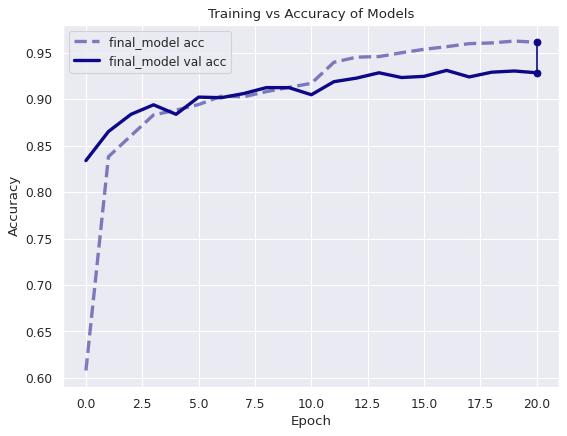

In [45]:
plot_acc(model_names, model_histories, include_delta=True, figsize=(8,6))

In [32]:
# Displaying performance
y_pred, y_true, df_report, _ = get_performance_report(final_model, features_test, labels_test, fashion_labels)
df_report

,precision,recall,f1-score,support,class_name
0,0.970464,0.931174,0.950413,247.000000,Sports Shoes
1,0.797980,0.858696,0.827225,184.000000,Kurtas
2,0.874074,0.861314,0.867647,274.000000,Tops
3,0.995595,1.000000,0.997792,226.000000,Handbags
4,0.947674,0.970238,0.958824,168.000000,Watches
5,0.803109,0.815789,0.809399,190.000000,Shirts
6,0.923372,0.892593,0.907721,270.000000,Tshirts
7,0.989071,0.994505,0.991781,182.000000,Casual Shoes
accuracy,0.913268,0.913268,0.913268,0.913268,N/A
macro avg,0.912667,0.915539,0.913850,1741.000000,N/A


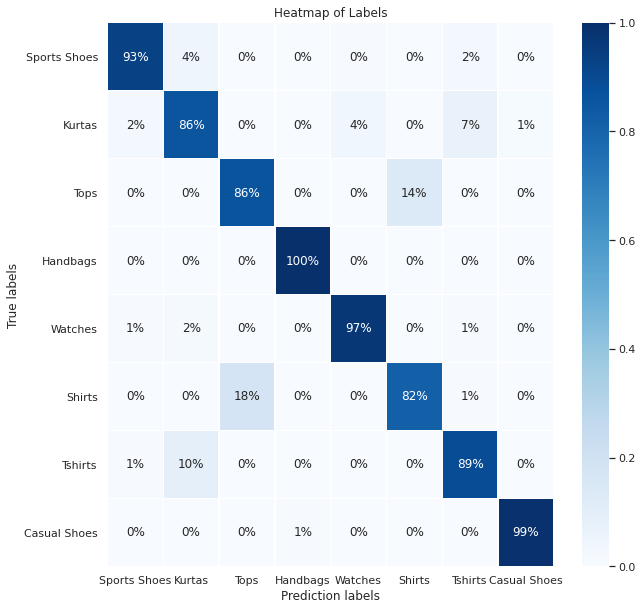

In [33]:
plot_confusion_matrix_heatmap(y_true, y_pred, fashion_labels, figsize=(10, 10))